In [1]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from keras.callbacks import ProgbarLogger
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier #!pip install scikeras
from keras.callbacks import ProgbarLogger

In [7]:
df = pd.read_csv('Titanic-Dataset.csv')
set(df[df.columns[-1]]) #df['Embarked']

{'C', 'Q', 'S', nan}

In [8]:
df['Embarked'] = df['Embarked'].fillna(method='ffill')

# One-hot encode 'Embarked' column
onehot_encoder = OneHotEncoder(sparse=False, drop='if_binary')
onehot_encoded = onehot_encoder.fit_transform(df[['Embarked']])
df[['Embarked_C', 'Embarked_Q', 'Embarked_S']] = onehot_encoded

# Create a mapping dictionary for regrouping
embarked_mapping = {'Embarked_C': 1, 'Embarked_Q': 2, 'Embarked_S': 3}

# Create 'Embarked' column by mapping the encoded values
df['Embarked'] = df[['Embarked_C', 'Embarked_Q', 'Embarked_S']].idxmax(axis=1)
df['Embarked'] = df['Embarked'].map(embarked_mapping)

# Drop the one-hot encoded columns
df.drop(['Embarked_C', 'Embarked_Q', 'Embarked_S','Name','Ticket','Cabin'], axis=1, inplace=True)

In [9]:
set(df[df.columns[-1]])

{1, 2, 3}

In [10]:
sex_mapping = {'male': 1, 'female': 0}
df['Sex'] = df['Sex'].map(sex_mapping)

In [11]:
df.head(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,3
1,2,1,1,0,38.0,1,0,71.2833,1
2,3,1,3,0,26.0,0,0,7.9250,3
3,4,1,1,0,35.0,1,0,53.1000,3
4,5,0,3,1,35.0,0,0,8.0500,3


In [12]:
# Separate the features (X) and target variable (y)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [15]:
preprocessor = ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'), slice(0, None))])

# Preprocess the numerical columns
X = preprocessor.fit_transform(X)

In [16]:
(len(df[df["Embarked"] == 1]),len(df[df["Embarked"] == 2]),len(df[df["Embarked"] == 3]))

(169, 78, 644)

In [17]:
over = RandomOverSampler()
X,y = over.fit_resample(X,y)
data = np.concatenate((X, y.reshape(-1, 1)), axis=1)


data = np.hstack(
    (X,np.reshape(y,(-1,1)))
)
data = pd.DataFrame(data,columns=df.columns)


In [18]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [19]:
(len(data[data["Embarked"] == 1]),len(data[data["Embarked"] == 2]),len(data[data["Embarked"] == 3]))

(644, 644, 644)

In [65]:
X_train,X_temp,y_train,y_temp = train_test_split(X,y,test_size=.1,random_state=0)
X_valid,X_test,y_valid,y_test = train_test_split(X_temp,y_temp,test_size=.2,random_state=0)

In [66]:
# Check for missing or NaN values in X_train (numpy array)
missing_values = np.isnan(X_train).sum() if isinstance(X_train, np.ndarray) else 0
print(missing_values)

0


In [67]:
# One-hot encoding for target variable
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_valid = encoder.transform(y_valid.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

In [67]:
loss_ = [tf.keras.losses.CategoricalCrossentropy(),
         tf.keras.losses.MSE]

optimizers_ = [tf.keras.optimizers.Adam(learning_rate=0.001),
               tf.keras.optimizers.RMSprop(learning_rate=0.001)]

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

for i in loss_:
    for j in optimizers_:
        model.compile(
            optimizer=j,
            loss=i,
            metrics=['accuracy']
        )
        model.fit(X_train, y_train, batch_size=64, epochs=40, validation_data=(X_valid, y_valid), verbose=0, callbacks=[ProgbarLogger(count_mode='steps')])
        accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
        print(f"accuracy = {accuracy}")


In [73]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(3, activation="softmax"))


model.compile(
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
            loss=tf.keras.losses.MSE,
            metrics=['accuracy']
        )
history =model.fit(X_train, y_train, batch_size=64, epochs=500, validation_data=(X_valid, y_valid), verbose=0, callbacks=[ProgbarLogger(count_mode='steps')])
accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
print(f"accuracy = {accuracy}")

accuracy = 0.6666666865348816


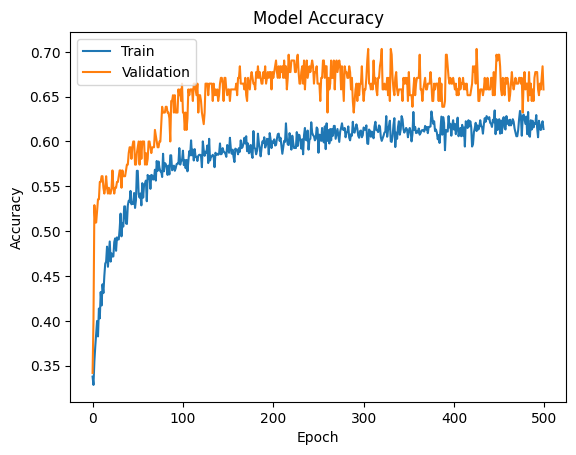

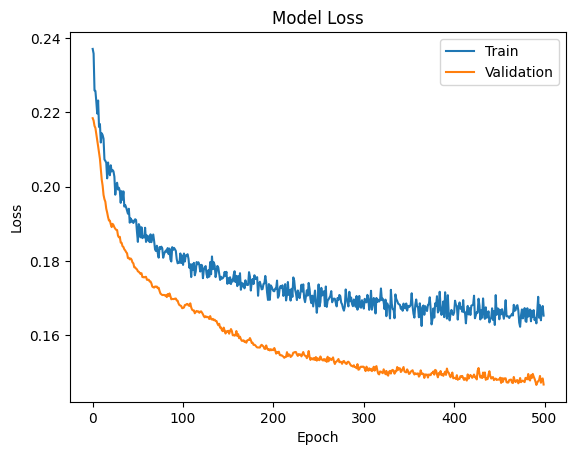

In [74]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
